# Model: Logistic Regression

## Imports and Settings

In [1]:
# Helper libraries
import warnings
from typing import List

# Scientific libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Local Imports
from churn_detection.utils import get_feature_names
from churn_detection.data import load_data
from churn_detection.visualization import plot_roc_curve, plot_confusion_table
from churn_detection.preprocessing import preprocess_data, split_data
from churn_detection.evaluation import (display_roc_auc_score, 
                                        display_clf_report, 
                                        validate_model_with_cv)
from churn_detection.features import (add_transformation, 
                                      DummyNumericTransformer, 
                                      FeatureRemover,
                                      ColumnPreprocessor, 
                                      Transformation,
                                      create_pipe, 
                                      engineer_features, 
                                      BaseEstimator, 
                                      Pipeline)


%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Various settings
warnings.filterwarnings("ignore")
np.set_printoptions(precision=4)
sns.set_theme()
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", None)

## Loading and Preparing Data

In [2]:
churn = load_data()

In [3]:
preprocessed_data = preprocess_data(churn)

In [4]:
prep_train, prep_test = train_test_split(
    preprocessed_data, 
    test_size=0.2, 
    random_state=1
)

X_train, y_train = split_data(prep_train)
X_test, y_test = split_data(prep_test)

## Data Modeling

In [5]:
_, categorical_variables = get_feature_names(preprocessed_data)

### Feature Tweaking

We will explore multiple quantile ranges for robust scaler on totalcharges feature.

In [6]:
BIMODAL_FEATURES = {
    "name": "bimodal",
    "variables": ["tenure", "monthlycharges"],
    "steps": [("dummy", StandardScaler())],
}

DISCRETE_FEATURES = {
    "name": "discrete",
    "variables": categorical_variables,
    "steps": [("encoder", OneHotEncoder(drop="if_binary", sparse_output=False))],
}

In [7]:
def generate_models(base_model: BaseEstimator, value_range: List[int]) -> List[Pipeline]:
    model_pipes = {}
    for value in value_range:
        feature_pipeline = ColumnPreprocessor()
        feature_pipeline.add_transformation(
            Transformation(**BIMODAL_FEATURES)
        )
        feature_pipeline.add_transformation(
            Transformation(**DISCRETE_FEATURES)
        )
        feature_pipeline.add_transformation(
            Transformation(
                name="skewed", 
                variables=["totalcharges"],
                steps=[("robust", RobustScaler(quantile_range=(value, 100-value))),]
            )
        )
        prep = feature_pipeline.create_preprocessor()
        pipe = create_pipe(prep, base_model)
        model_pipes[f"{value}-{100-value}"] = pipe
    return model_pipes

> 1-99: Mean 0.8420 - (Var 0.0167)
> 5-95: Mean 0.8421 - (Var 0.0167)
> 10-90: Mean 0.8422 - (Var 0.0167)
> 15-85: Mean 0.8423 - (Var 0.0167)
> 20-80: Mean 0.8424 - (Var 0.0167)
> 25-75: Mean 0.8424 - (Var 0.0167)
> 30-70: Mean 0.8425 - (Var 0.0168)
> 40-60: Mean 0.8425 - (Var 0.0168)


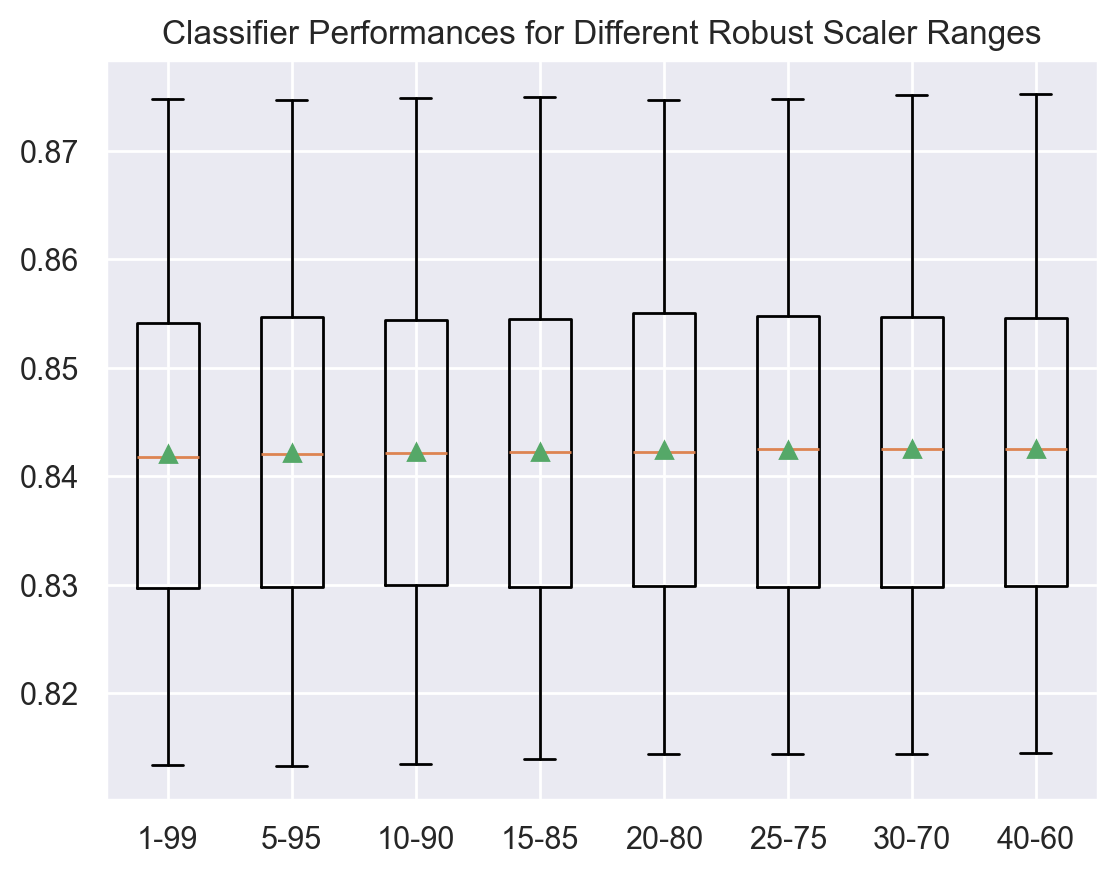

In [8]:
values = [1, 5, 10, 15, 20, 25, 30, 40]
models = generate_models(LogisticRegression(random_state=0), value_range=values)

results, names = [], []
for name, model in models.items():
    scores = validate_model_with_cv(
        model, train_data=(X_train, y_train), metric="roc_auc", results=True
    )
    results.append(scores)
    names.append(f"{name}")
    print(f"> {name}: Mean {np.mean(scores):.4f} - (Var {np.std(scores):.4f})")

plt.boxplot(results, labels=names, showmeans=True)
plt.title("Classifier Performances for Different Robust Scaler Ranges")
plt.show()

### Model Evaluation

#### Final Pipeline Setting

In [9]:
pipeline = ColumnPreprocessor()
pipeline.add_transformation(
    Transformation(**BIMODAL_FEATURES)
)
pipeline.add_transformation(
    Transformation(**DISCRETE_FEATURES)
)
pipeline.add_transformation(
    Transformation(
        name="skewed", 
        variables=["totalcharges"],
        steps=[("robust", RobustScaler(quantile_range=(40, 60))),]
    )
)

#### Final Score on Test Data

What interests us here for now is the % of churning users we can detect with our classifier and its default parameters.<br>
Thus essentially recall score on positive class and the deduced remaining % we fail to reach.

In [10]:
model = LogisticRegression(random_state=0)

In [11]:
transformers = pipeline.get_transformations()
train_features = engineer_features(X_train, transformers)
model.fit(train_features, y_train)

LogisticRegression(random_state=0)

In [12]:
# Test Data
test_features = engineer_features(X_test, transformers)
test_predictions = model.predict(test_features)
display_clf_report(test_predictions, y_test)

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1061
           1       0.63      0.60      0.61       348

    accuracy                           0.81      1409
   macro avg       0.75      0.74      0.74      1409
weighted avg       0.81      0.81      0.81      1409



#### Confusion Table on Test Set

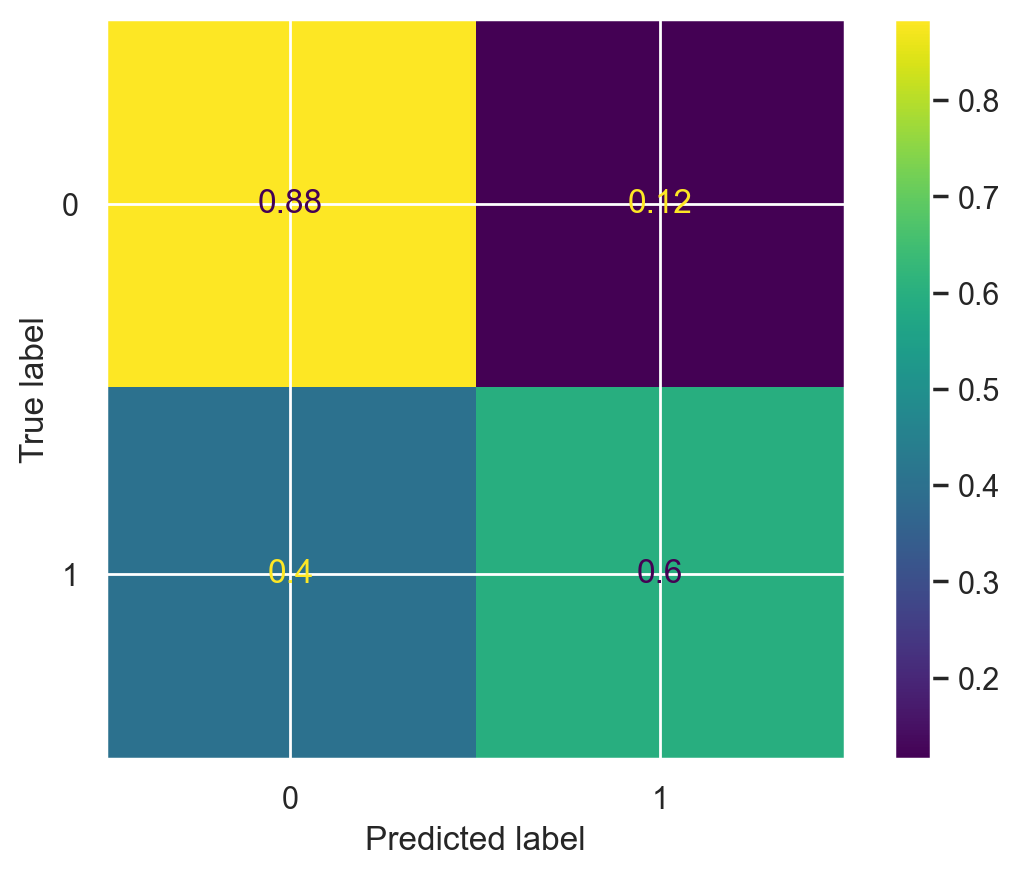

In [13]:
# Test Set
plot_confusion_table(y_test, test_predictions)

This classifier's skill is slightly better than previous one and capture 60 % of all churned customers.